In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os
import sys

from data.models import Player, GameStats, KtcValue

In [58]:
load_dotenv()
DB_USERNAME = os.environ['DB_USERNAME']
DB_PASSWORD = os.environ['DB_PASSWORD']
DB_HOST = os.environ['DB_HOST']
DB_PORT = os.environ['DB_PORT']
DB_NAME = os.environ['DB_NAME']

DB_URL = f"postgresql://{DB_USERNAME}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(DB_URL, echo=False)

Session = sessionmaker(bind=engine)
session = Session()

In [59]:
all_players = session.query(Player).filter(Player.ktc_values.any()).all()
values = session.query(Player.position, KtcValue.date ,KtcValue.value).join(KtcValue).all()

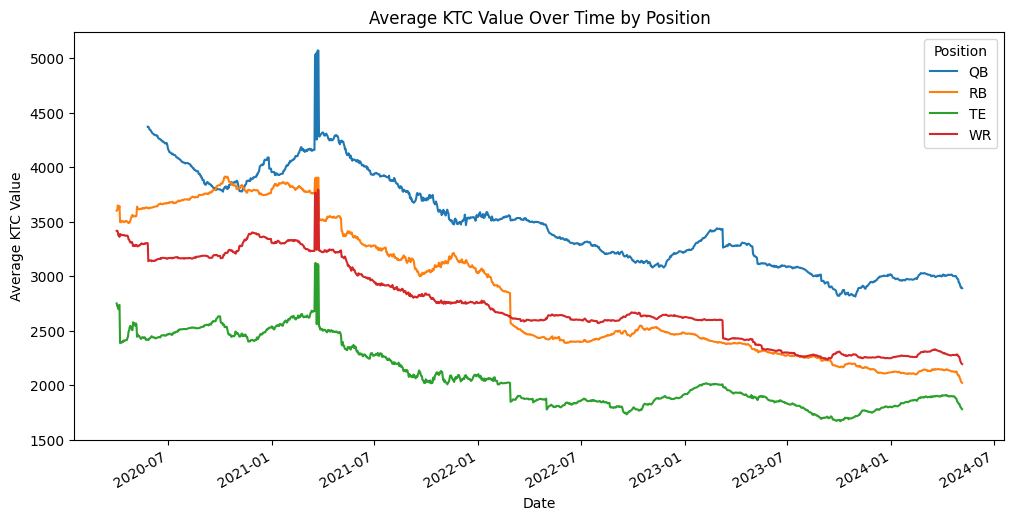

In [60]:
df = pd.DataFrame(values, columns=['position', 'date', 'value'])

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
grouped_df = df.groupby(['date', 'position']).mean().reset_index()

pivot_df = grouped_df.pivot(index='date', columns='position', values='value')

pivot_df.plot(figsize=(12, 6))
plt.title('Average KTC Value Over Time by Position')
plt.xlabel('Date')
plt.ylabel('Average KTC Value')
plt.legend(title='Position')
plt.show()

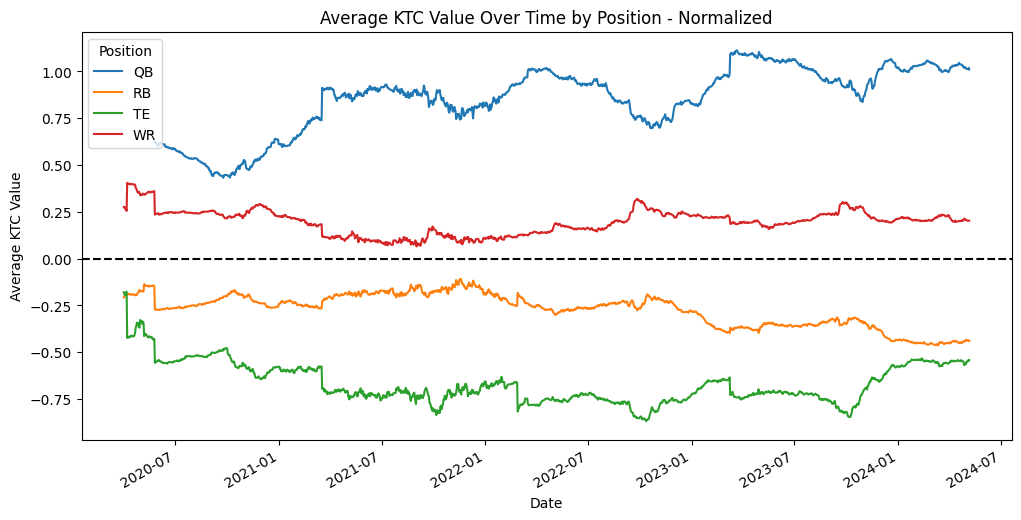

In [61]:
df = pd.DataFrame(values, columns=['position', 'date', 'value'])
# 3. Set the 'date' column as datetime
df['date'] = pd.to_datetime(df['date'])

qb_df = df[df['position'] == 'QB'].groupby('date').apply(lambda x: x.nlargest(20, 'value')).reset_index(drop=True)
rb_df = df[df['position'] == 'RB'].groupby('date').apply(lambda x: x.nlargest(40, 'value')).reset_index(drop=True)
wr_df = df[df['position'] == 'WR'].groupby('date').apply(lambda x: x.nlargest(40, 'value')).reset_index(drop=True)
te_df = df[df['position'] == 'TE'].groupby('date').apply(lambda x: x.nlargest(20, 'value')).reset_index(drop=True)
filtered_df = pd.concat([qb_df, rb_df, wr_df, te_df])

daily_mean = filtered_df.groupby('date')['value'].mean()
filtered_df = filtered_df.merge(daily_mean, on='date', suffixes=('', '_mean'))
filtered_df['normalized_difference'] = (filtered_df['value'] - filtered_df['value_mean']) / filtered_df.groupby(['date'])['value'].transform('std')

grouped_df = filtered_df.groupby(['date', 'position']).mean().reset_index()
pivot_df = grouped_df.pivot(index='date', columns='position', values='normalized_difference')

pivot_df.plot(figsize=(12, 6))
plt.title('Average KTC Value Over Time by Position - Normalized')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Average KTC Value')
plt.legend(title='Position')
plt.show()

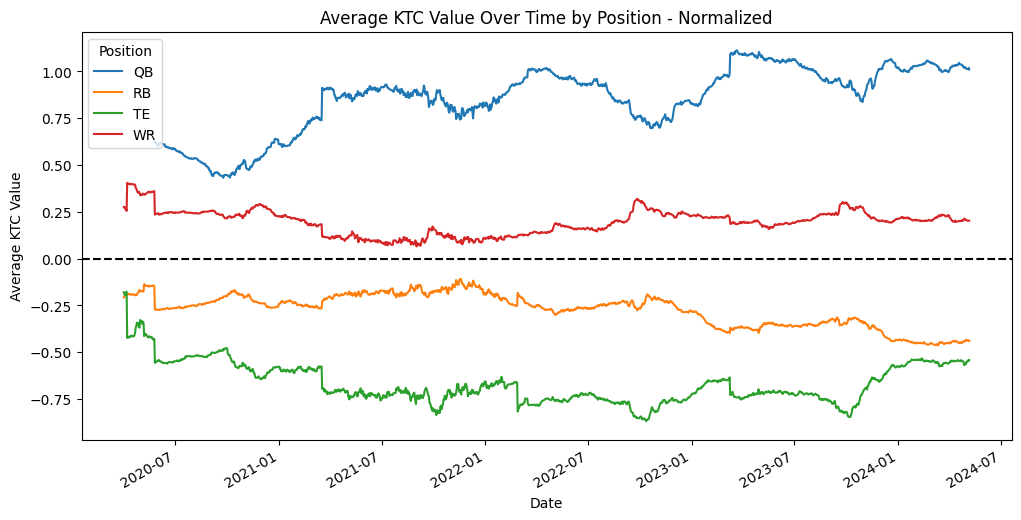

In [78]:
df = pd.DataFrame(values, columns=['position', 'date', 'value'])
# 3. Set the 'date' column as datetime
df['date'] = pd.to_datetime(df['date'])
qb_df = df[df['position'] == 'QB'].groupby('date').apply(lambda x: x.nlargest(20, 'value')).reset_index(drop=True)
rb_df = df[df['position'] == 'RB'].groupby('date').apply(lambda x: x.nlargest(40, 'value')).reset_index(drop=True)
wr_df = df[df['position'] == 'WR'].groupby('date').apply(lambda x: x.nlargest(40, 'value')).reset_index(drop=True)
te_df = df[df['position'] == 'TE'].groupby('date').apply(lambda x: x.nlargest(20, 'value')).reset_index(drop=True)
filtered_df = pd.concat([qb_df, rb_df, wr_df, te_df])

daily_mean = filtered_df.groupby('date')['value'].mean()
filtered_df = filtered_df.merge(daily_mean, on='date', suffixes=('', '_mean'))
filtered_df['normalized_difference'] = (filtered_df['value'] - filtered_df['value_mean']) / filtered_df.groupby(['date'])['value'].transform('std')

grouped_df = filtered_df.groupby(['date', 'position']).mean().reset_index()
pivot_df = grouped_df.pivot(index='date', columns='position', values='normalized_difference')

pivot_df.plot(figsize=(12, 6))
plt.title('Average KTC Value Over Time by Position - Normalized')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Average KTC Value')
plt.legend(title='Position')
plt.show()

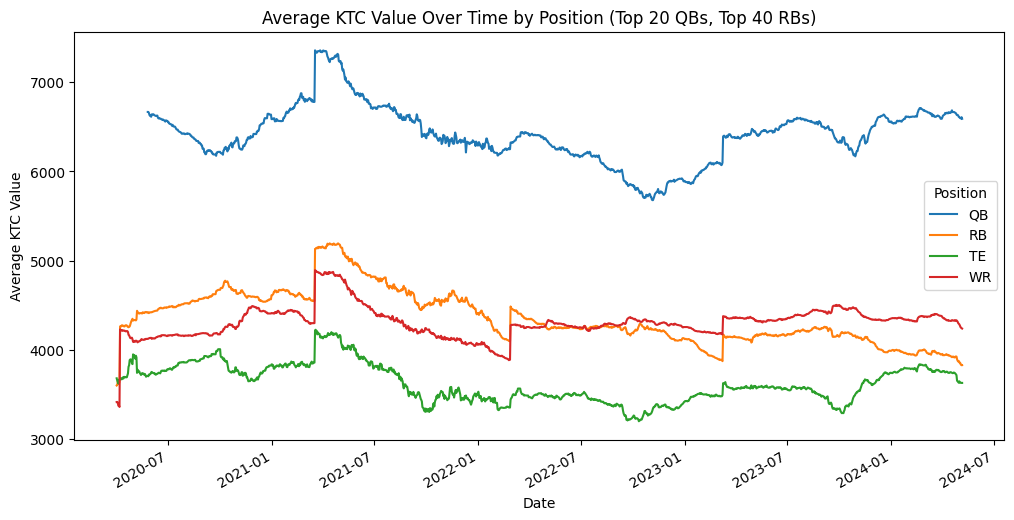

In [63]:
df = pd.DataFrame(values, columns=['position', 'date', 'value'])

# 3. Set the 'date' column as datetime
df['date'] = pd.to_datetime(df['date'])

# 4. Filter the data to include only the top 20 QBs and the top 40 RBs for each date
qb_df = df[df['position'] == 'QB'].groupby('date').apply(lambda x: x.nlargest(20, 'value')).reset_index(drop=True)
rb_df = df[df['position'] == 'RB'].groupby('date').apply(lambda x: x.nlargest(40, 'value')).reset_index(drop=True)
wr_df = df[df['position'] == 'WR'].groupby('date').apply(lambda x: x.nlargest(60, 'value')).reset_index(drop=True)
te_df = df[df['position'] == 'TE'].groupby('date').apply(lambda x: x.nlargest(20, 'value')).reset_index(drop=True)
filtered_df = pd.concat([qb_df, rb_df, wr_df, te_df])

# 5. Group by 'date' and 'position' and calculate the average KTC value for each group
grouped_df = filtered_df.groupby(['date', 'position']).mean().reset_index()

# 6. Pivot the DataFrame to have 'position' as columns
pivot_df = grouped_df.pivot(index='date', columns='position', values='value')

# 7. Plot the timeseries data for each position
pivot_df.plot(figsize=(12, 6))
plt.title('Average KTC Value Over Time by Position (Top 20 QBs, Top 40 RBs)')
plt.xlabel('Date')
plt.ylabel('Average KTC Value')
plt.legend(title='Position')
plt.show()

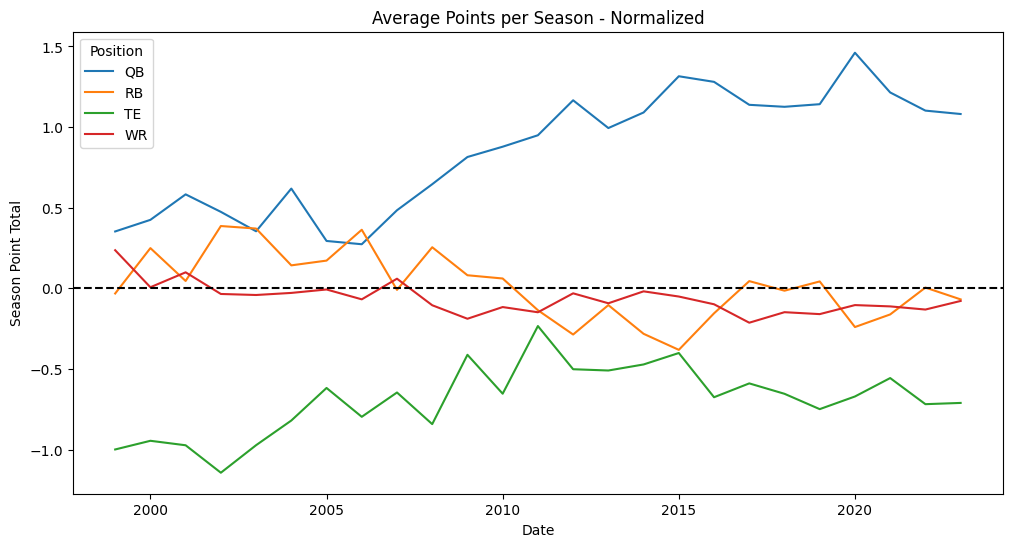

In [91]:
game_stats = session.query(Player.position, Player.id, GameStats.fantasy_points_ppr, GameStats.season, GameStats.season_type)\
                   .join(GameStats).filter(GameStats.season_type == 'REG') \
                   .filter(Player.position.in_(('QB', 'RB', 'WR', 'TE'))).all()

# 2. Convert the query results into a DataFrame
df = pd.DataFrame(game_stats, columns=['position', 'id', 'fantasy_points_ppr', 'season', 'season_type'])
df = df[df['season_type'] == 'REG']

# 3. Sum the fantasy points for each player by season
summed_df = df.groupby(['id', 'season', 'position'])['fantasy_points_ppr'].sum().reset_index()

summed_df.head()
# 4. Filter the DataFrame to include only the top players for each position
filtered_df = pd.concat([
    summed_df[summed_df['position'] == 'QB'].groupby('season').apply(lambda x: x.nlargest(20, 'fantasy_points_ppr')).reset_index(drop=True),
    summed_df[summed_df['position'] == 'RB'].groupby('season').apply(lambda x: x.nlargest(40, 'fantasy_points_ppr')).reset_index(drop=True),
    summed_df[summed_df['position'] == 'WR'].groupby('season').apply(lambda x: x.nlargest(60, 'fantasy_points_ppr')).reset_index(drop=True),
    summed_df[summed_df['position'] == 'TE'].groupby('season').apply(lambda x: x.nlargest(20, 'fantasy_points_ppr')).reset_index(drop=True)
])

season_mean = filtered_df.groupby('season')['fantasy_points_ppr'].mean()
filtered_df = filtered_df.merge(season_mean, on='season', suffixes=('', '_mean'))
filtered_df['normalized_difference'] = (filtered_df['fantasy_points_ppr'] - filtered_df['fantasy_points_ppr_mean']) / filtered_df.groupby(['season'])['fantasy_points_ppr'].transform('std')

grouped_df = filtered_df.groupby(['season', 'position']).mean().reset_index()
pivot_df = grouped_df.pivot(index='season', columns='position', values='normalized_difference')

pivot_df.plot(figsize=(12, 6))
plt.title('Average Points per Season - Normalized')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Season Point Total')
plt.legend(title='Position')
plt.show()


In [ ]:
session.close()